![image.png](https://i.imgur.com/a3uAqnb.png)


# Fine-tuning Vision Transformer for Bird Species Classification: CUB-200-2011 Dataset
- **Images**: Bird photos from 200 different species **(varied sizes, RGB)**
- **Classes**: 200 bird species with scientific and common names
- **Task**: Multi-class image classification using a pre-trained ViT
- **Model**: Google's ViT-Large-Patch16-224 fine-tuned for bird species recognition

This notebook is heavily inspired by this [Hugging Face ViT fine-tuning tutorial](https://huggingface.co/learn/cookbook/en/fine_tuning_vit_custom_dataset).


## 🎯 **What is Vision Transformer (ViT)?**
Vision Transformer treats images as sequences of patches, similar to how text transformers process word tokens:

1️⃣ **Patch Embedding** → Split image into 16x16 patches and embed them  
2️⃣ **Position Encoding** → Add positional information to patches  
3️⃣ **Transformer Encoder** → Process patch sequences with self-attention  
4️⃣ **Classification Head** → Final layer for class prediction  

Unlike CNNs, ViT uses **attention mechanisms** to understand spatial relationships between image patches.


## 1️⃣ **Dataset Setup & Preprocessing**

### Installing Dependencies and Importing Libraries

In [1]:
# Essential libraries for ViT fine-tuning
import kagglehub  # For downloading Kaggle datasets
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Hugging Face ecosystem
from datasets import Dataset, DatasetDict, load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

# PyTorch for deep learning
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop, Compose, Normalize, RandomHorizontalFlip,
    RandomResizedCrop, ToTensor, Resize, RandomRotation, ColorJitter
)

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import ViTForImageClassification

In [23]:
import numpy as np
from tqdm import tqdm

### Downloading the CUB-200-2011 Dataset


In [2]:
print("Downloading dataset...")

# Download latest version
path = kagglehub.dataset_download("wenewone/cub2002011")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/cub2002011


In [3]:
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class CUBDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = Path(images_dir)
        self.transform = transform

        # Clean class names by removing prefix before first dot
        raw_class_names = sorted(entry.name for entry in self.images_dir.iterdir() if entry.is_dir())
        self.class_names = [name.split('.', 1)[1] if '.' in name else name for name in raw_class_names]
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        # Map raw -> cleaned class name
        raw_to_clean = {
            raw: clean for raw, clean in zip(raw_class_names, self.class_names)
        }

        # Collect (image_path, label_index) pairs
        self.data = []
        for raw_class_name in raw_class_names:
            clean_class_name = raw_to_clean[raw_class_name]
            class_idx = self.class_to_idx[clean_class_name]
            class_dir = self.images_dir / raw_class_name
            for img_file in class_dir.glob("*.jpg"):
                self.data.append((img_file, class_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
from torchvision import transforms

# Creating the dataset
dataset = CUBDataset("/kaggle/input/cub2002011/CUB_200_2011/images", transform=None)

# TODO: Complete the following print statements:
print(f"Total images: {................}")
print(f"Example 15 class names: {................}")


Total images: 11796
Example class names: ['Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani', 'Crested_Auklet']


In [5]:
from torch.utils.data import random_split

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size  # Ensure total sum

    # Use fixed seed for reproducibility
    generator = torch.Generator().manual_seed(seed)

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    return train_set, val_set, test_set


In [6]:
# TODO: Complete the following split function arguments.
# split data into 70% train, 15% validaiton, and 15% test.
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=......., val_ratio=......., test_ratio=.......)

print(len(train_dataset), len(val_dataset), len(test_dataset))

8257 1769 1770


In [29]:
import matplotlib.pyplot as plt
import random

def visualize_random_samples(dataset, class_names=None, num_samples=9):
    """
    Visualize random samples from a dataset.

    Args:
        dataset: PyTorch Dataset instance that returns (image, label).
        class_names: Optional list mapping label indices to class names.
        num_samples: Number of samples to show (default 9).
    """
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    plt.figure(figsize=(12, 12))
    for i, (img, label) in enumerate(samples):
        plt.subplot(int(num_samples ** 0.5), int(num_samples ** 0.5), i + 1)

        # img can be tensor or PIL image
        if hasattr(img, 'permute'):  # tensor
            img = img.permute(1, 2, 0).cpu().numpy()
            img = img.clip(0, 1)
        elif hasattr(img, 'numpy'):  # PIL or similar
            img = img if isinstance(img, (plt.cm.ScalarMappable, plt.AxesImage)) else img

        plt.imshow(img)
        plt.axis('off')
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(str(label))
    plt.tight_layout()
    plt.show()


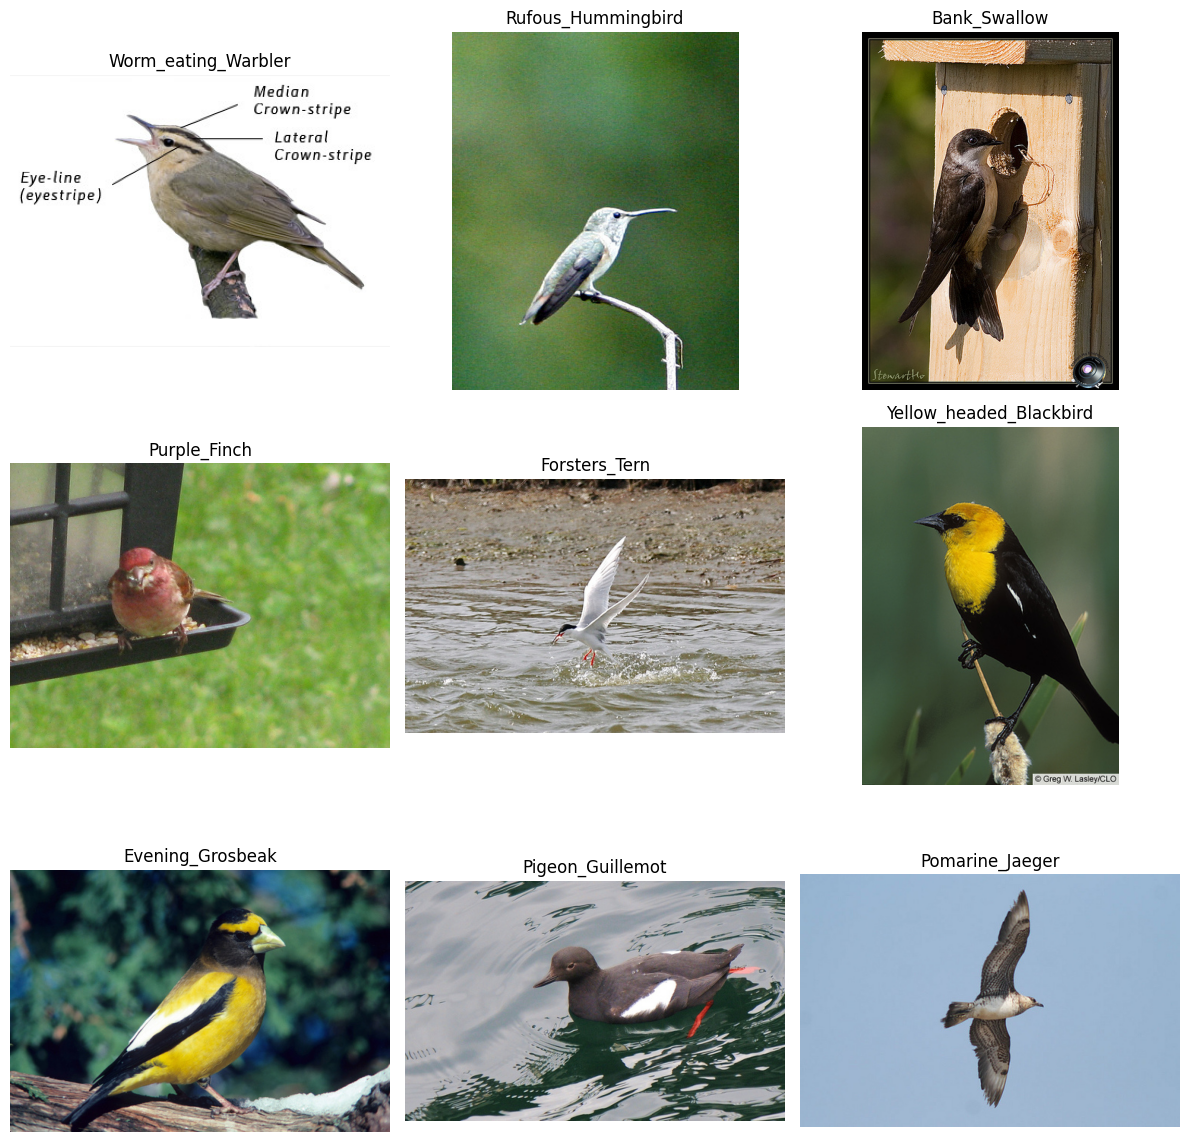

In [8]:
# TODO: Visualize 9 samples using the following function
visualize_random_samples

In [9]:
# 🔹 Initialize the ViT processor
# This handles image preprocessing according to the pre-trained model's requirements
# TODO: complete the following (you can refer to the lab)
model_name = ......
processor = ......

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
# 🔹 Get processor parameters for data augmentation
image_mean, image_std = processor.image_mean, processor.image_std
# TODO: Complete the following
size = ......

print(f"Image shape: {......}x{......}")
print(f"Image mean: {......}")
print(f"Image std: {......}")

Image size: 224x224
Image mean: [0.5, 0.5, 0.5]
Image std: [0.5, 0.5, 0.5]


In [11]:
from torch.utils.data import Dataset

class TransformableSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset  # this is a torch.utils.data.Subset
        self.transform = transform

    def set_transform(self, transform):
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [12]:
# 🔹 Define transformations
# TODO: Define a normalization same as the pre-trained model!
normalize = ......


# Define all the transofrmation you want
train_transforms = Compose([

])

# Define all the transofrmation you want
val_transforms = Compose([

])

# Define all the transofrmation you want
test_transforms = Compose([

])

In [13]:
train_dataset = TransformableSubset(train_dataset, train_transforms)
val_dataset = TransformableSubset(val_dataset, val_transforms)
test_dataset = TransformableSubset(test_dataset, test_transforms)


In [14]:
# TODO: Create data loaders with smaller batch sizes for memory efficiency
# Hint: ViT-Large requires significant GPU memory, so we use smaller batches
train_dataloader = DataLoader(......)
val_dataloader = DataLoader(......)
test_dataloader = DataLoader(......)

In [15]:
# TODO: Test batch preparation to ensure everything works (try one of the dataloaders)




shape: torch.Size([32, 3, 224, 224])


In [16]:
# TODO: Create id to label dictionary and label to id.
# Hint: use dataset.class_names

id2label = ......
label2id = ......

print(id2label)
print(label2id)

{0: 'Black_footed_Albatross', 1: 'Laysan_Albatross', 2: 'Sooty_Albatross', 3: 'Groove_billed_Ani', 4: 'Crested_Auklet', 5: 'Least_Auklet', 6: 'Parakeet_Auklet', 7: 'Rhinoceros_Auklet', 8: 'Brewer_Blackbird', 9: 'Red_winged_Blackbird', 10: 'Rusty_Blackbird', 11: 'Yellow_headed_Blackbird', 12: 'Bobolink', 13: 'Indigo_Bunting', 14: 'Lazuli_Bunting', 15: 'Painted_Bunting', 16: 'Cardinal', 17: 'Spotted_Catbird', 18: 'Gray_Catbird', 19: 'Yellow_breasted_Chat', 20: 'Eastern_Towhee', 21: 'Chuck_will_Widow', 22: 'Brandt_Cormorant', 23: 'Red_faced_Cormorant', 24: 'Pelagic_Cormorant', 25: 'Bronzed_Cowbird', 26: 'Shiny_Cowbird', 27: 'Brown_Creeper', 28: 'American_Crow', 29: 'Fish_Crow', 30: 'Black_billed_Cuckoo', 31: 'Mangrove_Cuckoo', 32: 'Yellow_billed_Cuckoo', 33: 'Gray_crowned_Rosy_Finch', 34: 'Purple_Finch', 35: 'Northern_Flicker', 36: 'Acadian_Flycatcher', 37: 'Great_Crested_Flycatcher', 38: 'Least_Flycatcher', 39: 'Olive_sided_Flycatcher', 40: 'Scissor_tailed_Flycatcher', 41: 'Vermilion_Fly

In [17]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels=len(id2label),
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Set the device
device = ......
print("Device is:", device)

Device is: cuda


In [20]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # predicted classes

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [22]:
# TODO: Set up optimizer
optimizer = ......

num_epochs = 5

In [24]:
train_losses_per_epoch = []
val_losses_per_epoch = []

In [25]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_total = 0

    all_train_preds = []
    all_train_labels = []

    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")
    for images, labels in loop:

        # TODO: Complete the training loop for one epoch
        # TODO: Make sure to show the values that compute_matrix returns.
        # Hint: Do not forget to keep track of the losses per epoch

        pass # Remove when solving



    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation")
    for images, labels in val_loop:
        # TODO: Complete the training loop for one epoch
        # TODO: Make sure to show the values that compute_matrix returns.
        # Hint: Do not forget to keep track of the losses per epoch





Epoch 3 Validation:   0%|          | 0/56 [00:00<?, ?it/s, accuracy=0.0000, f1=0.0000, loss=5.2986, precision=0.0000, recall=0.0000]


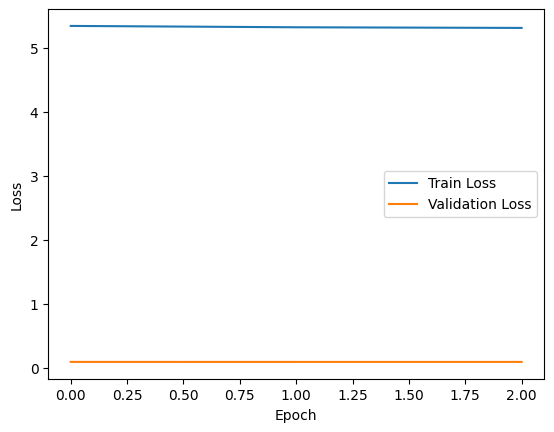

In [26]:
import matplotlib.pyplot as plt

# TODO: Plot training and validation losses.



In [27]:
from tqdm import tqdm
import numpy as np

model.eval()

# TODO: test your model on test_dataloader.
# Note that this step must be the final step, so if the results are not good, it is over ;)



Test Evaluation: 100%|██████████| 56/56 [00:33<00:00,  1.69it/s]



FINAL RESULT

Test accuracy: 0.0045, precision: 0.0067, recall: 0.0045, f1: 0.0031


In [ ]:
# TODO: Evaluate the model with different matrices on test data.



In [ ]:
# TODO: Create a confusion matrix for some classes.





In [ ]:
# TODO: Show a classification report.




In [ ]:
# TODO: Show per class accuracy.





### Contributed by: Hassan Alsayhah

![image.png](https://i.imgur.com/a3uAqnb.png)